<a href="https://colab.research.google.com/github/MoMahmoud8/Alzheimer-Parkinson-Diseases/blob/main/Alzheimer_Parkinson_Diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/farjanakabirsamanta/alzheimer-diseases-3-class")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mostafamahmoudhassan
Your Kaggle Key: ··········


100%|██████████| 48.7M/48.7M [00:00<00:00, 61.6MB/s]


In [3]:
import numpy as np # Linear algebra
import os
import matplotlib.pyplot as plt # ploting library for simple plots

import cv2
from tqdm import tqdm
import io
import seaborn as sns # ploting utility

from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard,ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model

import ipywidgets as widgets
from PIL import Image
from IPython.display import display, clear_output


In [4]:
labels = ['CONTROL', 'AD', 'PD']


In [56]:
labels.index('PD')

2

In [46]:
X = [] #Training Dataset
Y = [] #Training Labels

image_size=150

for i in labels:
    folderPath = os.path.join('/content/alzheimer-diseases-3-class/3_cls/train', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X.append(image)
        Y.append(i)


for i in labels:
    folderPath = os.path.join('/content/alzheimer-diseases-3-class/3_cls/test', i) # Join two or more pathname components
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X.append(image)
        Y.append(i)

#Image and Label is appended as list, now is to be converted into array
X = np.array(X)
Y = np.array(Y)

100%|██████████| 61/61 [00:00<00:00, 1320.43it/s]


In [47]:
print(X.shape)
print(Y.shape)

(7839, 150, 150, 3)
(7839,)


In [48]:
X, Y = shuffle(X, Y, random_state=42)


In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
print(X_train.shape)
print(X_test.shape)

(7055, 150, 150, 3)
(784, 150, 150, 3)


In [50]:
Y_train[100]

'AD'

In [51]:
y_train_new = []
y_test_new = []

for i in Y_train:
    y_train_new.append(labels.index(i))#Converting String Label to integer i.e
                                       # CONTROL ---> 0, AD---> 1, PD ---> 2
Y_train = to_categorical(y_train_new) #Converts a class vector (integers) to binary class matrix

for i in Y_test:
    y_test_new.append(labels.index(i))

Y_test = to_categorical(y_test_new)


In [30]:
# Y_train=to_categorical(Y_train)
# Y_test=to_categorical(Y_test)

In [52]:
Y_train[0]

array([0., 1., 0.], dtype=float32)

In [36]:
# Input of model
efficientnet_B0 = EfficientNetB0(include_top=False,
    weights='imagenet',
    input_shape=(image_size, image_size, 3))


16705208/16705208 [==============================] - 0s 0us/step


In [37]:
# Output of model
model = efficientnet_B0.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(3, activation='softmax')(model)


In [38]:
#Merge input and Output of model
model = tf.keras.models.Model(inputs=efficientnet_B0.input, outputs=model)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 150, 150, 3)  0           ['normalization[0][0]']      

In [39]:
#Configures the model for training
model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc'])


In [43]:
tensorBoard = TensorBoard(log_dir="logs")
checkPoint = tf.keras.callbacks.ModelCheckpoint(filepath='efficient_net_B0.h5',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.3,
                             patience=2,
                             verbose=1,
                             mode='auto',
                             min_delta=0.001)
es = EarlyStopping(monitor='val_loss',
                   patience=5,
                   verbose=1,
                   mode='auto',
                   restore_best_weights=True)


In [53]:
history = model.fit(X_train,
                    Y_train,
                    batch_size=32,
                    validation_split=0.1,
                    epochs=20,
                    verbose=1,
                    callbacks=[tensorBoard, checkPoint, reduce_lr, es])

Epoch 1/20
199/199 [==============================] - ETA: 0s - loss: 0.7177 - acc: 0.6083
Epoch 1: val_loss improved from 0.99789 to 0.65078, saving model to efficient_net_B0.h5
199/199 [==============================] - 27s 131ms/step - loss: 0.7177 - acc: 0.6083 - val_loss: 0.6508 - val_acc: 0.6473 - lr: 9.0000e-05
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.5373 - acc: 0.7335
Epoch 2: val_loss improved from 0.65078 to 0.55773, saving model to efficient_net_B0.h5
199/199 [==============================] - 26s 132ms/step - loss: 0.5373 - acc: 0.7335 - val_loss: 0.5577 - val_acc: 0.7280 - lr: 9.0000e-05
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.4010 - acc: 0.8206
Epoch 3: val_loss improved from 0.55773 to 0.33858, saving model to efficient_net_B0.h5
199/199 [==============================] - 27s 133ms/step - loss: 0.4010 - acc: 0.8206 - val_loss: 0.3386 - val_acc: 0.8569 - lr: 9.0000e-05
Epoch 4/20
199/199 [====================

In [65]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
actual_label = np.argmax(Y_test, axis=1)
print(classification_report(actual_label, pred))


25/25 [==============================] - 1s 31ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       360
           1       0.98      0.99      0.98       317
           2       0.96      0.92      0.94       107

    accuracy                           0.97       784
   macro avg       0.97      0.96      0.96       784
weighted avg       0.97      0.97      0.97       784



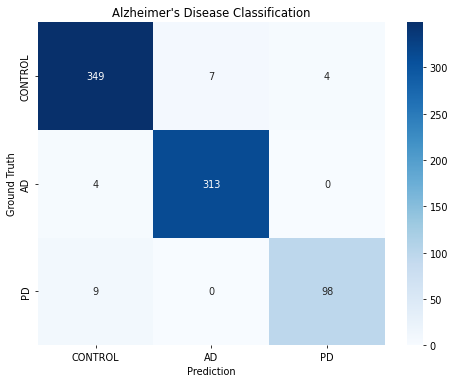

In [66]:
cnf = confusion_matrix(actual_label, pred)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues',annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Alzheimer\'s Disease Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)


In [67]:
def imagePrediction(upload):
    for name, fileinfo  in uploader.value.items():
        image = Image.open(io.BytesIO(fileinfo['content']))

    images = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    images = cv2.resize(images,(150, 150))
    images = images.reshape(1, 150, 150, 3)
    prd = model.predict(images)
    prd = np.argmax(prd, axis = 1)[0]


    if prd == 0:
        prd = "CONTROL"
    elif prd == 1:
        prd = "AD"
    elif prd ==2:
        prd = "PD"

    print(f'Model Predict That is  a {prd}')


In [68]:
uploader = widgets.FileUpload()
display(uploader)


FileUpload(value={}, description='Upload')

In [69]:
button = widgets.Button(description= "Predict")
out = widgets.Output()

def on_button_click(_):
    with out:
        clear_output()
        try:
            imagePrediction(uploader)
        except:
            print("Please Enter the Correct Image files")


button.on_click(on_button_click)
widgets.VBox([button, out])
